In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import MinMaxScaler, TargetEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from kan import *
import torch

In [ ]:
def get_binary_metrics(y_true, y_pred):
    """Отображает Accuracy, Precision, Recall, F1 в виде столбцов"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
    
    return metrics


def plot_normalized_confusion_matrix(y_true, y_pred):
    """Строит нормализованную по классам матрицу ошибок"""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, 
                annot=True, 
                fmt='.0%',
                cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def plot_roc_curve(y_true, y_scores):
    """Строит ROC-кривую и считает AUC"""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


def plot_probability_distribution(y_true, y_scores, bins=100):
    plt.figure(figsize=(10, 6))
    
    sns.histplot(
        y_scores[y_true == 1], 
        bins=bins, 
        color='blue', 
        alpha=0.6,
        label='Class 1 (True)',
        kde=True
    )
    
    sns.histplot(
        y_scores[y_true == 0], 
        bins=bins, 
        color='red', 
        alpha=0.6,
        label='Class 0 (True)',
        kde=True
    )
    
    plt.title('Predicted Probability Distribution by True Class', fontsize=14)
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7)
    plt.text(0.52, plt.ylim()[1]*0.9, 'Decision Threshold (0.5)', 
             fontsize=10, color='gray')
    plt.show()


def plot_classification_evaluation(y_true, y_pred, y_proba):
    metrics = get_binary_metrics(y_true, y_pred)
    print(metrics)
    plot_normalized_confusion_matrix(y_true, y_pred)
    plot_roc_curve(y_true, y_proba)
    plot_probability_distribution(y_true, y_proba)


def plot_logistic_coefs(model, feature_names):
    coefs = model.coef_[0]
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    
    top_idx = sorted_idx[:100000]
    top_coefs = coefs[top_idx]
    top_features = [feature_names[i] for i in top_idx]
    
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in top_coefs]
    plt.barh(top_features, top_coefs, color=colors)
    
    plt.axvline(0, color='gray', linestyle='--')
    plt.title('Top 10 Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

In [ ]:
data = pd.read_csv("personality_datasert.csv")
data.head(2)

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data["Personality"].value_counts()

In [ ]:
X = data.drop('Personality', axis=1)
y = data['Personality']

le = LabelEncoder()
y = le.fit_transform(y)

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
numeric_features = [
    'Time_spent_Alone', 
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

categorical_features = [
    'Stage_fear',
    'Drained_after_socializing'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Обработка пропусков
    ('scaler', MinMaxScaler())                   # Нормализация
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Обработка пропусков
    ('te', TargetEncoder(random_state=42)) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

preprocessor.fit(X_train, y_train)
preprocessor

In [ ]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

pred_train_lr, proba_train_lr = model_lr.predict(X_train), model_lr.predict_proba(X_train)[:, -1]
pred_test_lr, proba_test_lr = model_lr.predict(X_test), model_lr.predict_proba(X_test)[:, -1]
model_lr

In [ ]:
print("TRAIN:")
print(get_binary_metrics(y_train, pred_train_lr))
print("TEST")
plot_classification_evaluation(y_test, pred_test_lr, proba_test_lr)

In [ ]:
plot_logistic_coefs(model_lr, features)

In [186]:
model = KAN(width=[X.shape[1], 3, 2], grid=10, k=3, seed=42, device=device)
model

checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [187]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dtype = torch.get_default_dtype()

def train_acc():
    preds = torch.argmax(model(kan_ds['train_input']), dim=1)
    return torch.mean((preds == kan_ds['train_label']).float())

def test_acc():
    preds = torch.argmax(model(kan_ds['test_input']), dim=1)
    return torch.mean((preds == kan_ds['test_label']).float())

kan_ds = {}
kan_ds['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
kan_ds['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
kan_ds['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
kan_ds['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

model.fit(kan_ds, steps=5, loss_fn=torch.nn.CrossEntropyLoss(), metrics=(train_acc, test_acc))

cpu


| train_loss: 4.02e-01 | test_loss: 5.34e-01 | reg: 2.95e+01 | : 100%|█| 5/5 [00:03<00:00,  1.62it/s

saving model version 0.1


{'train_loss': [array(0.44708684, dtype=float32),
  array(0.42812142, dtype=float32),
  array(0.41743258, dtype=float32),
  array(0.4092481, dtype=float32),
  array(0.40202466, dtype=float32)],
 'test_loss': [array(0.49915627, dtype=float32),
  array(0.5032942, dtype=float32),
  array(0.5182889, dtype=float32),
  array(0.5237915, dtype=float32),
  array(0.53446656, dtype=float32)],
 'reg': [array(0., dtype=float32),
  array(0., dtype=float32),
  array(0., dtype=float32),
  array(0., dtype=float32),
  array(29.519321, dtype=float32)],
 'train_acc': [0.9397701025009155,
  0.9397701025009155,
  0.9393103718757629,
  0.9416092038154602,
  0.9429885149002075],
 'test_acc': [0.9186207056045532,
  0.9158620834350586,
  0.9158620834350586,
  0.913103461265564,
  0.9144827723503113]}

TRAIN:
{'Accuracy': 0.9429885057471264, 'Precision': 0.9268069533394327, 'Recall': 0.9583727530747398, 'F1-Score': 0.9423255813953488}
TEST
{'Accuracy': 0.9144827586206896, 'Precision': 0.8877005347593583, 'Recall': 0.9431818181818182, 'F1-Score': 0.9146005509641874}


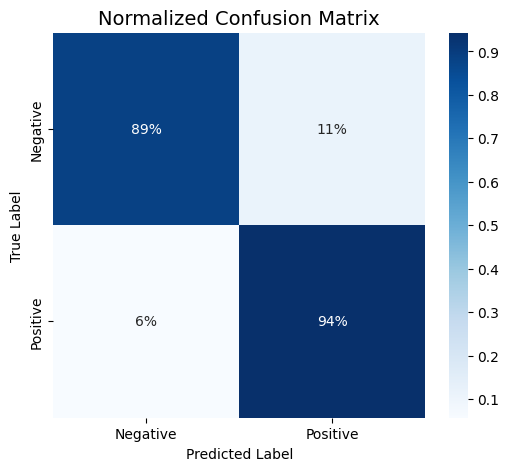

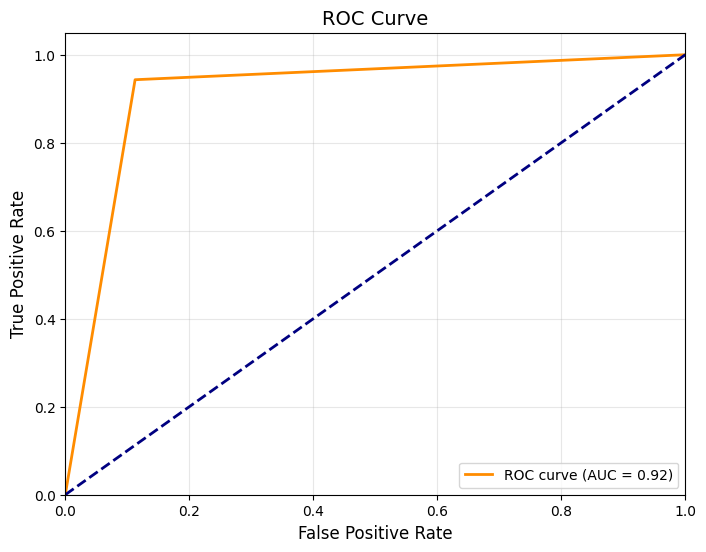

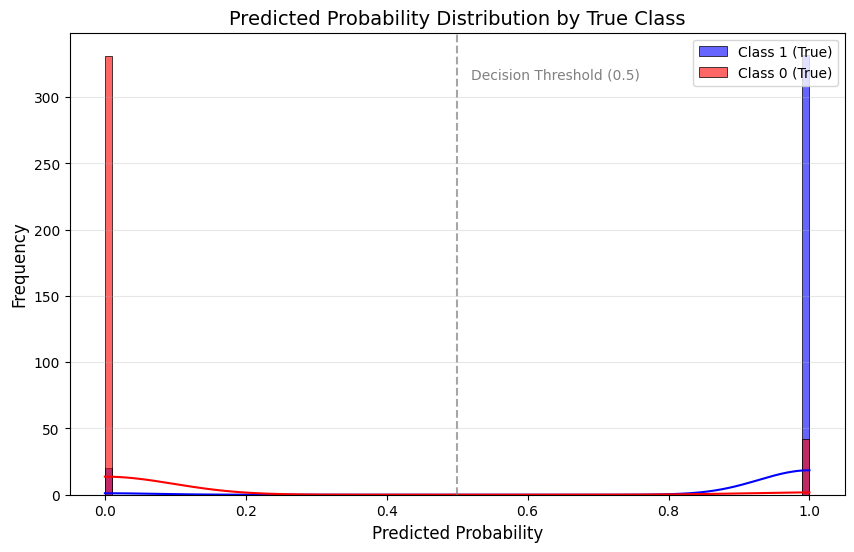

In [188]:
pred_train_kan = torch.argmax(model.forward(kan_ds['train_input']).detach(),dim=1).cpu().detach().numpy()
pred_test_kan = torch.argmax(model.forward(kan_ds['test_input']).detach(),dim=1).cpu().detach().numpy()

proba_test_kan = pred_test_kan

print("TRAIN:")
print(get_binary_metrics(y_train, pred_train_kan))
print("TEST")
plot_classification_evaluation(y_test, pred_test_kan, proba_test_kan)

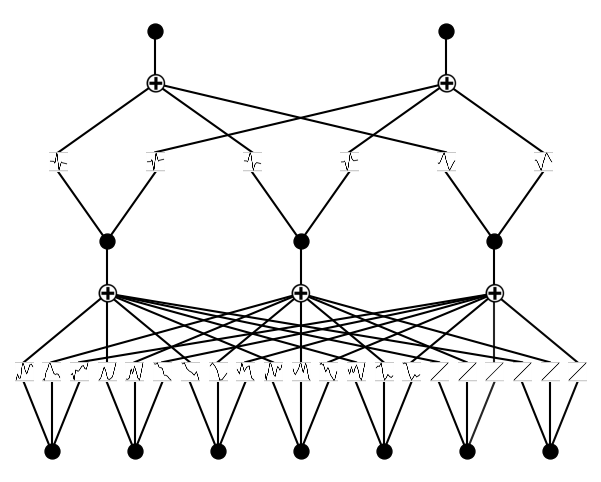

In [189]:
model.plot(beta=100, scale=0.75)

In [181]:
model.auto_symbolic()

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with 0, r2=0.0, c=0
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,3,0) with 0, r2=0.0, c=0
fixing (0,3,1) with 0, r2=0.0, c=0
fixing (0,4,0) with 0, r2=0.0, c=0
fixing (0,4,1) with 0, r2=0.0, c=0
fixing (0,5,0) with x, r2=1.0000007152557373, c=1
fixing (0,5,1) with x, r2=1.0000007152557373, c=1
fixing (0,6,0) with x, r2=1.0000007152557373, c=1
fixing (0,6,1) with x, r2=1.0000007152557373, c=1
saving model version 0.2
